# Ocular disease detecting project

## Deep Learning

## Project: Build a Ocular Decease  Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## What is Diabetic Retinopathy?

Diabetic Retinopathy is an eye disease associated with long-standing diabetes. This happens when high blood sugar levels cause damage to blood vessels in the retina. These blood vessels can swell and leak. Or they can close, stopping blood from passing through. Sometimes abnormal new blood vessels grow on the retina. All of these changes can steal your vision. You can follow this link to find more about it.

![Diabetic Retinopathy](dr_explanation.png)

## Data

We were provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A clinician had rated the presence of diabetic retinopathy in each image between 0 and 4, according to the following scale:

**0** - No DR

**1** - Mild

**2** - Moderate

**3** - Severe

**4** - Proliferative DR


Our task was to create an automated DR detector capable of assigning a score to a given image based on this scale.

In [1]:
#import all the required libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline


import PIL

In [2]:
#Testing GPU

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
#Label Dictionary for  number to text
d_label = {0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

In [4]:
#datafile location variables

datafile_path = '/media/drive2/vikram/workspace/tmp-ws/jama16-retina-replication/data/eyepacs/pool'
datafile_csv = datafile_path + '/trainLabels.csv'

level_sample = False #take equal count of all the samples when set to True
maxcount_per_level = 40000
maxcount_per_level_limiting = False

In [5]:
#Load the data from the csv file
data = pd.read_csv(datafile_csv)

print(datafile_path +'/'+str(data['level'][10])+'/'+data['image'][10]+'.jpeg')

print(data.shape)
print(data.columns)

/media/drive2/vikram/workspace/tmp-ws/jama16-retina-replication/data/eyepacs/pool/0/19_left.jpeg
(35120, 2)
Index(['image', 'level'], dtype='object')


In [6]:
#Function to hot-encode
from sklearn.feature_extraction import DictVectorizer

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [7]:
data = one_hot(data, cols=['level'])
data.head()

,image,level,level_0,level_1,level_2,level_3,level_4
0,10_left,0,1,0,0,0,0
1,10_right,0,1,0,0,0,0
2,13_left,0,1,0,0,0,0
3,13_right,0,1,0,0,0,0
4,15_left,1,0,1,0,0,0


In [8]:
if level_sample == True:
    level0 = data[data['level'] == 0]
    level1 = data[data['level'] == 1]
    level2 = data[data['level'] == 2]
    level3 = data[data['level'] == 3]
    level4 = data[data['level'] == 4]
    
    print ("Level0 = {}, level1 = {}, Level2 = {}, Level3={}, Level4={}" \
       .format(level0.shape[0], level1.shape[0], level2.shape[0], level3.shape[0], level4.shape[0]))
    
    if((maxcount_per_level_limiting == True) and (maxcount_per_level < count_for_training)):
        count_for_training = maxcount_per_level
    else:
        count_for_training = int((min(level0.shape[0], level1.shape[0], level2.shape[0], level3.shape[0], level4.shape[0])))
    
    print ("Count for training {}".format(count_for_training))
    
    level0.reset_index(drop=True, inplace=True)              #added drop=True
    level0 = level0[level0.index < count_for_training]
    level1.reset_index(drop=True, inplace=True)
    level1 = level1[level1.index < count_for_training]
    level2.reset_index(drop=True, inplace=True)
    level2 = level2[level2.index < count_for_training]
    level3.reset_index(drop=True, inplace=True)
    level3 = level3[level3.index < count_for_training]
    level4.reset_index(drop=True, inplace=True)
    level4 = level4[level4.index < count_for_training]
    
    data = pd.concat([level0, level1, level2, level3, level4])


In [9]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,image,level,level_0,level_1,level_2,level_3,level_4
0,192_right,2,0,0,1,0,0
1,27165_right,1,0,1,0,0,0
2,9412_right,0,1,0,0,0,0
3,2261_right,1,0,1,0,0,0
4,13827_right,0,1,0,0,0,0


In [10]:
y = np.array(data.drop(['image', 'level'], axis=1))
count_for_training = y.shape[0]
y.shape

(35120, 5)

In [11]:
#Reading all the image files and creating an image array in a fixed image size of 400,400,3
import threading
import os
import cv2

def grayscale(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Normalizes the data between 0.1 and 0.9 instead of 0 to 255    
def normalize(data):
    return data / 255.0 * 0.8 + 0.1


def load_img(img_array, start, end):
    #print("Load Image assigned to thread: {}".format(threading.current_thread().name)) 
    #print("ID of process running Load Image: {}".format(os.getpid())) 
    
    for i in (range(start,end)):
        #img = image.load_img((datafile_path+train['image'][i]+'.jpeg'),target_size=(224,224,3))
        img = image.load_img((datafile_path+'/'+str(data['level'][i])+'/'+data['image'][i]+'.jpg'),target_size=(224,224,3))
        rotation_angle = np.random.randint(360)
        # rotate the image
        img = img.rotate(rotation_angle)
        img = image.img_to_array(img)
        img = grayscale(img)
        img = (normalize(img))
        img_array.append(img)
        
    return img_array

    
from PIL import Image, ImageOps

count = int(data.shape[0])
print ('Count =', count)
#train_image = []
train_image1 = []
train_image2 = []
train_image3 = []
train_image4 = []

#t1 = threading.Thread(target=load_img, args=(train_image1, 0, count//4)) 
#t2 = threading.Thread(target=load_img, args=(train_image2, (count//4), count//2)) 
#t3 = threading.Thread(target=load_img, args=(train_image3, count//2, (count//4)*3))
#t4 = threading.Thread(target=load_img, args=(train_image4, (count//4)*3, count)) 
t1 = threading.Thread(target=load_img, args=(train_image1, 0, count))

t1.start()
#t2.start()
#t3.start()
#t4.start()

t1.join()
#t2.join()
#t3.join()
#t4.join()

images = train_image1 + train_image2 + train_image3 + train_image4

print ("Image loading complete")

Count = 35120
Image loading complete


In [12]:
x = np.array(images)

x.shape

(35120, 224, 224, 3)

From original data array
11909_right 0
From x and y arrays
Level from y array: [1 0 0 0 0]


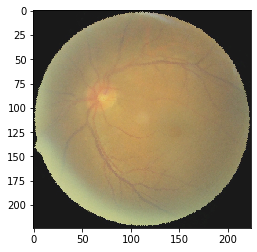

In [13]:
#Print a sample image with results
import random
num = random.randint(1, (count_for_training-1))
print("From original data array")
print(data['image'][num], data['level'][num])

print("From x and y arrays")
plt.imshow(x[num])
print("Level from y array: " + str(y[num]))

In [14]:
#splitting the data set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42, test_size=0.1)
print("training and validation set ready")

training and validation set ready


In [15]:

from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights = None, include_top=False, input_shape=(224, 224, 3))

# Add a new top layer
arr = base_model.output
arr = Flatten()(arr)
arr = Dropout(0.2)(arr)
arr = Dense(32, activation='relu')(arr)
arr = Dropout(0.2)(arr)
arr = Dense(16, activation='relu')(arr)
predictions = Dense(5, activation='softmax')(arr)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)




model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(5, activation='softmax'))

In [16]:


opti = tf.keras.optimizers.Adam(learning_rate=0.001,   epsilon=1e-07)
#opti = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.1, momentum=0.0, epsilon=1e-07, centered=True)

model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1)] 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
#Training the model
epochs_count = 100
bsize = 32

checkpoint_path = './'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path+'model.h5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, mode='auto'
)

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

print ('\n\nNote : First Epoch takes time to load, so be patient, it is not hanging \n')

history = model.fit(x_train, y_train, epochs=epochs_count, validation_data=(x_val, y_val), 
                    callbacks=[cp_callback, early_stopping_monitor], batch_size=bsize)



Note : First Epoch takes time to load, so be patient, it is not hanging 

Epoch 1/100
988/988 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.7332
Epoch 00001: val_loss improved from inf to 0.89426, saving model to ./model.h5
988/988 [==============================] - 983s 995ms/step - loss: 1.0416 - accuracy: 0.7332 - val_loss: 0.8943 - val_accuracy: 0.7192
Epoch 2/100
988/988 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.7366
Epoch 00002: val_loss improved from 0.89426 to 0.89299, saving model to ./model.h5
988/988 [==============================] - 609s 616ms/step - loss: 0.8650 - accuracy: 0.7366 - val_loss: 0.8930 - val_accuracy: 0.7192
Epoch 3/100
988/988 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.7366
Epoch 00003: val_loss did not improve from 0.89299
988/988 [==============================] - 604s 611ms/step - loss: 0.8648 - accuracy: 0.7366 - val_loss: 0.8937 - val_accuracy: 0.7192
Epoch 4/100
988

In [18]:
#Plotting the accuracy graph

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss_val)+1)

plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
#plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import prettytable
from prettytable import PrettyTable

table = PrettyTable()
table.add_column("Epochs", epochs)
table.add_column("Accuracy", val_accuracy)
print(table)

NameError: name 'loss_val' is not defined

In [ ]:
#A function for prediction 

def predict_DR(file, actual,verbose=True):
    img = image.load_img(file,target_size=(224,224,3))
    img = image.img_to_array(img)
    img = (img/255)
    
    proba = model.predict(img.reshape(1,224,224,3))
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("              No DR    : Mild     : Moderate  : Severe : Proliferative DR")
    print("Probabilty", proba)
    #print(proba)
    
    idx = np.argmax(proba, axis=1)
    proba = np.zeros(proba.shape)
    proba[np.arange(proba.shape[0]), idx]=1
    #plt.imshow(img)
    for i in (range(5)):
        if (proba[0][i] == 1):
            result = i
            print ("Image Name ", file)
            print ("Predicted Result : ", d_label[i])
            print ("Actual Result    : ", d_label[actual])
    if(verbose == 1):
        plt.imshow(img)   
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    
    if (result == actual):
        ret_val = 1
    else:
        ret_val = 0
    return (ret_val)


def predict_DRI(img, actual):
    proba = model.predict(img.reshape(1,224,224,3))
    #print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    #print("              No DR    : Mild     : Moderate  : Severe : Proliferative DR")
    #print("Probabilty", proba)
    ##print(proba)
    
    idx = np.argmax(proba, axis=1)
    proba = np.zeros(proba.shape)
    proba[np.arange(proba.shape[0]), idx]=1
  
    for i in (range(5)):
        if (proba[0][i] == 1):
            #print ("Predicted Result : ", d_label[i])
            result = i
            #print ("Actual Result    : ", d_label[actual])
    #plt.imshow(img)
            
    #print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    if (result == actual):
        ret_val = 1
    else:
        ret_val = 0
    return (ret_val)

In [1]:
#This is the Diabetic Retinopathy level of the image above
#count_for_training = 900
sumcnt = 0
count = 50
accuracy = []
trials = range(1, 11)

import prettytable 
from prettytable import PrettyTable

table = PrettyTable()

for t in range(10):
    sumcnt = 0
    for i in (range(count)):
        rand_level = random.randint(0, 5)
        sno = random.randint(0, len(data[data['level'] == rand_level]))
        result = (data['level'][sno])
        #print("Sample ID :", sno, "Result -", result, "Label -",d_label[result],data['image'][sno])
        sumcnt = sumcnt + predict_DRI(x[sno],result)
    accuracy.append(sumcnt/count)  
  
plt.plot(trials, accuracy)
plt.xlabel('trials')
plt.ylabel('accuracy')
plt.title('Accuracy over 10 trials')
table.add_column("Trial", trials)
table.add_column("Accuracy", accuracy)
print(table)
print("Each trial contains 50 epochs.")
print("Average Accuracy: " + str(np.mean(accuracy)))

NameError: name 'random' is not defined